------

# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## 1. Preparación

1.1 Carga de los datos y librerias

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error

from catboost import Pool, CatBoostRegressor
import lightgbm as lgb

import calendar

In [2]:
data = pd.read_csv('/datasets/taxi.csv', parse_dates=[0],index_col=[0])
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


1.2 Verificacion y muestreo del indice en intervalos de una hora.

In [3]:
print('El indice se encuentra organizado:    ',data.index.is_monotonic_increasing)
data = data.resample("1H").sum()
print('\n','Verificacion de las primeros 15 observaciones','\n',data.head(15),'\n','# de observaciones:   ',len(data))

El indice se encuentra organizado:     True

 Verificacion de las primeros 15 observaciones 
                      num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43
2018-03-01 05:00:00           6
2018-03-01 06:00:00          12
2018-03-01 07:00:00          15
2018-03-01 08:00:00          34
2018-03-01 09:00:00          69
2018-03-01 10:00:00          64
2018-03-01 11:00:00          96
2018-03-01 12:00:00          30
2018-03-01 13:00:00          32
2018-03-01 14:00:00          48 
 # de observaciones:    4416


## 2. Análisis

2.1 Rango de los datos

In [4]:
print('Fecha de inicio de los datos:   ',data.index.min())
print('Fecha final de los datos:   ',data.index.max())
print('Observaciones con valores ausentes:   ',data.isna().sum())

Fecha de inicio de los datos:    2018-03-01 00:00:00
Fecha final de los datos:    2018-08-31 23:00:00
Observaciones con valores ausentes:    num_orders    0
dtype: int64


La serie temporal va desde 2018-03-01 hasta 2018-08-31, con el numero de pedidos de taxis por hora.

2.2 Verificacion de tendecias y estacionalidad (Marzo, abril y Mayo)

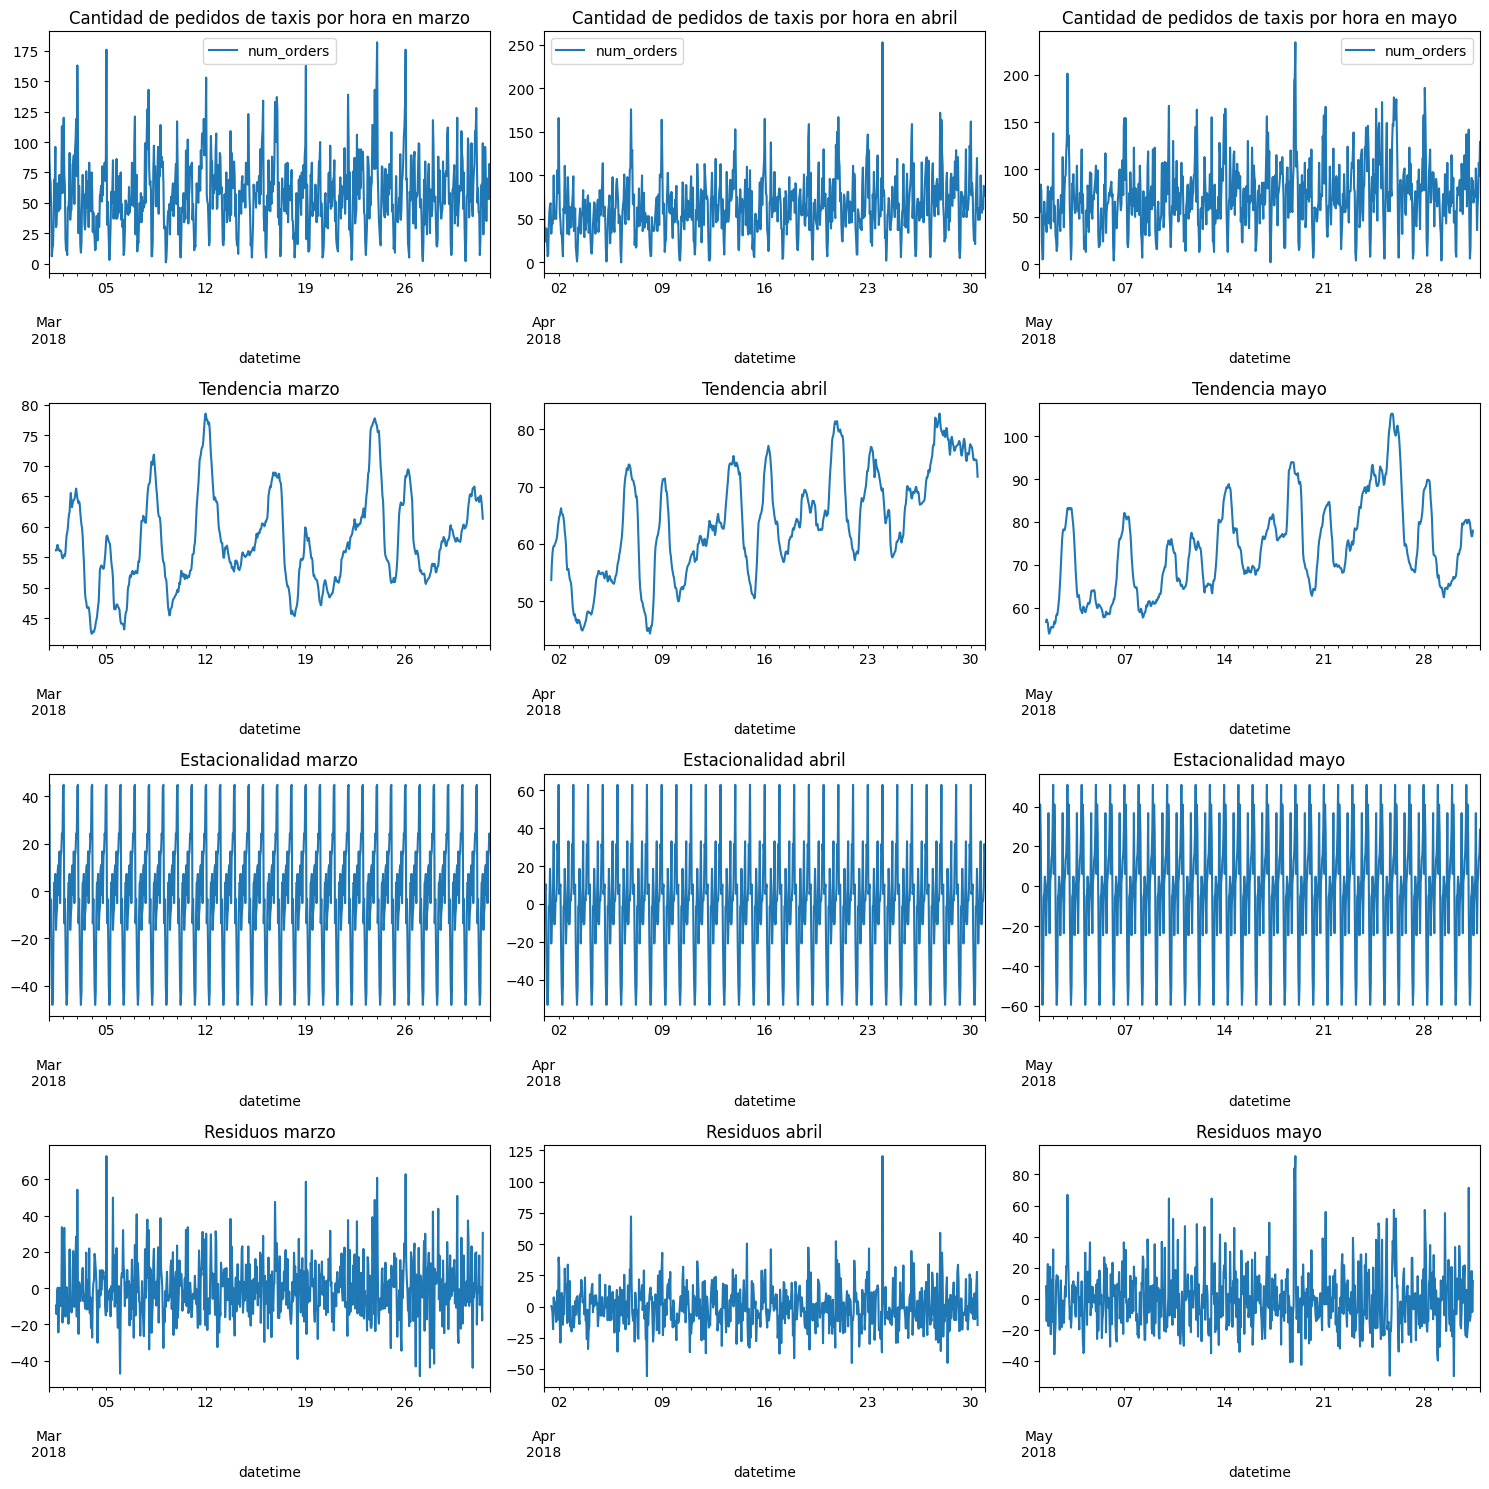

In [5]:
decomposed_mar = seasonal_decompose(data['2018-03-01':'2018-03-31'])
decomposed_ap = seasonal_decompose(data['2018-04-01':'2018-04-30'])
decomposed_may = seasonal_decompose(data['2018-05-01':'2018-05-31'])
# Pedidos en general
plt.figure(figsize=(15, 15))
plt.subplot(431)
data['2018-03-01':'2018-03-31'].plot(ax=plt.gca(),title='Cantidad de pedidos de taxis por hora en marzo')
plt.subplot(432)
data['2018-04-01':'2018-04-30'].plot(ax=plt.gca(),title='Cantidad de pedidos de taxis por hora en abril')
plt.subplot(433)
data['2018-05-01':'2018-05-31'].plot(ax=plt.gca(),title='Cantidad de pedidos de taxis por hora en mayo')
# Tendencia
plt.subplot(434)
decomposed_mar.trend.plot(ax=plt.gca(),title='Tendencia marzo')
plt.subplot(435)
decomposed_ap.trend.plot(ax=plt.gca(),title='Tendencia abril')
plt.subplot(436)
decomposed_may.trend.plot(ax=plt.gca(),title='Tendencia mayo')
#Estacionalidad
plt.subplot(437)
decomposed_mar.seasonal.plot(ax=plt.gca(),title='Estacionalidad marzo')
plt.subplot(438)
decomposed_ap.seasonal.plot(ax=plt.gca(),title='Estacionalidad abril')
plt.subplot(439)
decomposed_may.seasonal.plot(ax=plt.gca(),title='Estacionalidad mayo')
#residuos
plt.subplot(4,3,10)
decomposed_mar.resid.plot(ax=plt.gca(),title='Residuos marzo')
plt.subplot(4,3,11)
decomposed_ap.resid.plot(ax=plt.gca(),title='Residuos abril')
plt.subplot(4,3,12)
decomposed_may.resid.plot(ax=plt.gca(),title='Residuos mayo')
plt.tight_layout()

In [6]:
for i in range(3,6):
    print(calendar.month(2018,i))

     March 2018
Mo Tu We Th Fr Sa Su
          1  2  3  4
 5  6  7  8  9 10 11
12 13 14 15 16 17 18
19 20 21 22 23 24 25
26 27 28 29 30 31

     April 2018
Mo Tu We Th Fr Sa Su
                   1
 2  3  4  5  6  7  8
 9 10 11 12 13 14 15
16 17 18 19 20 21 22
23 24 25 26 27 28 29
30

      May 2018
Mo Tu We Th Fr Sa Su
    1  2  3  4  5  6
 7  8  9 10 11 12 13
14 15 16 17 18 19 20
21 22 23 24 25 26 27
28 29 30 31



Se generaron las graficas de tendencias, estacionalidad y residuos para los meses de Marzo, Abril y Mayo para realizar un analisis inicial de los datos:

- Los datos presentan una estacionalidad diaria, en la cual las cantidad de pedidos aumenta segun la hora del dia.
- Los dias con mayor numero de pedidos fueron los dias sabado y lunes, con una disminucion los domingos.
- Mayo presento un numero mayor de pedidos con respectos a los otros dos meses.
- El promedio de pedidos en abril aumento desde la mitad del mes

## 3. Formación

3.1 Creacion de caracterizticas

In [7]:
# Caracterizticas de mes, dia y dias del mes-----------------------------------------------------------------------------------------------------
data['month'] = data.index.month
data['day'] = data.index.day
data['dayofweek'] = data.index.dayofweek
# Caracterizticas de media y std movil con una ventana de 5
data["rolling_mean"]=data['num_orders'].shift().rolling(5).mean()   
data["rolling_std"]=data['num_orders'].shift().rolling(5).std()
# Caracteriztica de de diferencia de series temporales, dejando el primer valor como 0
data["diff"]=data['num_orders'] - data['num_orders'].shift(5,fill_value=0)
# 3 Caracterizticas de desfase
for lag in range(1,4):
    data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

3.2 Divison de conjunto de datos 9:1 y eliminacion de observaciones con valores ausentes

In [8]:
train,test=train_test_split(data,test_size=0.1,shuffle=False)
train=train.dropna()

3.3 Verificacion de los datos finales

3.3.1 No existen valores NaN en los conjnutos de datos

In [9]:
print("Verificacion Conjunto de entrenamiento:     ","\n","-------------------------------------------------------")
train.info()
print("\n","Verificacion Conjunto de prueba:     ","\n","-------------------------------------------------------")
test.info()

Verificacion Conjunto de entrenamiento:      
 -------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3969 entries, 2018-03-01 05:00:00 to 2018-08-13 13:00:00
Freq: H
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    3969 non-null   int64  
 1   month         3969 non-null   int64  
 2   day           3969 non-null   int64  
 3   dayofweek     3969 non-null   int64  
 4   rolling_mean  3969 non-null   float64
 5   rolling_std   3969 non-null   float64
 6   diff          3969 non-null   int64  
 7   lag_1         3969 non-null   float64
 8   lag_2         3969 non-null   float64
 9   lag_3         3969 non-null   float64
dtypes: float64(5), int64(5)
memory usage: 341.1 KB

 Verificacion Conjunto de prueba:      
 -------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 442 entries, 2018-08-13 14:

3.3.2 La secuencia temporal de los datos de entrenamiento y prueba es correcta, los datos de prueba son consecutivos a los de entrenamiento

conjunto de entrenamiento:    
 Primeros 5 valores del indice 
 DatetimeIndex(['2018-03-01 05:00:00', '2018-03-01 06:00:00',
               '2018-03-01 07:00:00', '2018-03-01 08:00:00',
               '2018-03-01 09:00:00'],
              dtype='datetime64[ns]', name='datetime', freq='H') 
 Ultimos 5 valores del indice 
 DatetimeIndex(['2018-08-13 09:00:00', '2018-08-13 10:00:00',
               '2018-08-13 11:00:00', '2018-08-13 12:00:00',
               '2018-08-13 13:00:00'],
              dtype='datetime64[ns]', name='datetime', freq='H')
------------------------------------------------
conjunto de prueba:    
 Primeros 5 valores del indice 
 DatetimeIndex(['2018-08-13 14:00:00', '2018-08-13 15:00:00',
               '2018-08-13 16:00:00', '2018-08-13 17:00:00',
               '2018-08-13 18:00:00'],
              dtype='datetime64[ns]', name='datetime', freq='H') 
 Ultimos 5 valores del indice 
 DatetimeIndex(['2018-08-31 19:00:00', '2018-08-31 20:00:00',
               '2018-08-3

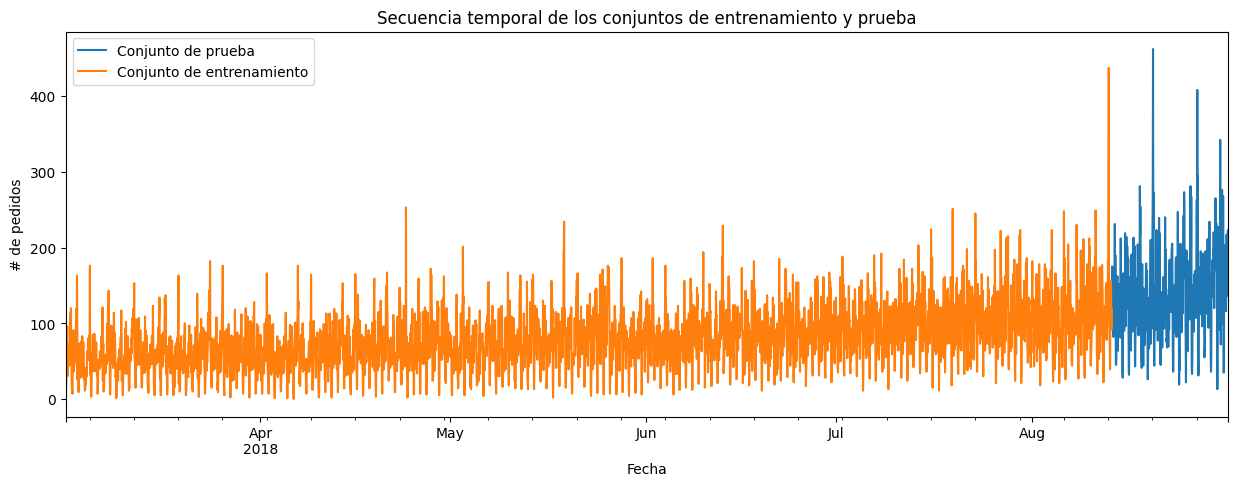

In [10]:
print('conjunto de entrenamiento:   ','\n',"Primeros 5 valores del indice",'\n',train.head(5).index,'\n',"Ultimos 5 valores del indice",'\n',train.tail(5).index)
print("------------------------------------------------")
print('conjunto de prueba:   ','\n',"Primeros 5 valores del indice",'\n',test.head(5).index,'\n',"Ultimos 5 valores del indice",'\n',test.tail(5).index)
print("------------------------------------------------")
plt.figure(figsize=(15, 5))
test['num_orders'].plot(ax=plt.gca(),title='Secuencia temporal de los conjuntos de entrenamiento y prueba')
train['num_orders'].plot()
plt.legend( ['Conjunto de prueba', 'Conjunto de entrenamiento'])
plt.xlabel('Fecha')
plt.ylabel('# de pedidos')
plt.show()

Los datos de entrenamiento se encuentran divididos correctamente y no existen datos futuros en el conjunto de entrenamiento.

3.4 Division de los conjuntos de datos para creacion y prueba del modelo
TRAIN: 

features_train, target_train

TEST: 

features_test, target_test


In [11]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [12]:
print("Valores ausentes conjuntos de datos train:   ",'\n',"Features_train: ",'\n')
features_train.info()
print('\n',"Target_train: ",'\n',target_train.isna().sum())
print("-------------------------------------")
print("Valores ausentes conjuntos de datos test:   ",'\n',"Features_test: ",'\n')
features_test.info()
print('\n',"Target_test: ",'\n',target_test.isna().sum())

Valores ausentes conjuntos de datos train:    
 Features_train:  

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3969 entries, 2018-03-01 05:00:00 to 2018-08-13 13:00:00
Freq: H
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   month         3969 non-null   int64  
 1   day           3969 non-null   int64  
 2   dayofweek     3969 non-null   int64  
 3   rolling_mean  3969 non-null   float64
 4   rolling_std   3969 non-null   float64
 5   diff          3969 non-null   int64  
 6   lag_1         3969 non-null   float64
 7   lag_2         3969 non-null   float64
 8   lag_3         3969 non-null   float64
dtypes: float64(5), int64(4)
memory usage: 310.1 KB

 Target_train:  
 0
-------------------------------------
Valores ausentes conjuntos de datos test:    
 Features_test:  

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 442 entries, 2018-08-13 14:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (tot

-------------------------------------------------------------------------------------------------------------

No existen valores NAN en ninguno de los conjuntos obtenidos con Train y test.

## 4. Prueba

Se crearon y probaron diferentes modelos variando sus hiperparametros hasta encontrar el modelo con el mejor RECM utilizando los datos de prueba.

4.1 Regresion lineal

4.2 Bosque aleatorio

4.3 Bosque aleatorio CatBoost

4.4 Bosque aleatorio LightGBM

4.5 Decision Tree

4.6 Decision Tree LightGBM

4.7 K-vecinos

-------------------------------------------------------------------------------------------------------------------------------------------------------

4.1 Regresion lineal

In [13]:
%%time
# Prueba del modelo --------------------------------------
model = LinearRegression()
model.fit(features_train, target_train)
prediction_rl = model.predict(features_test)
print('El mejor RECM obtenido con el conjunto de prueba utilizando modelo de Regresion Lineal es:', mean_squared_error(target_test, prediction_rl)**0.5)

El mejor RECM obtenido con el conjunto de prueba utilizando modelo de Regresion Lineal es: 25.56336092257272
CPU times: user 3.41 ms, sys: 4.76 ms, total: 8.17 ms
Wall time: 4.93 ms


4.2 Bosque aleatorio

In [14]:
%%time
best_recm_forest = 1000
best_est = 0
best_depth=0
for est in range(1,72,10):
    for depth in range(1,11):
        model_forest = RandomForestRegressor(random_state=12345, n_estimators=est,max_depth=depth)
        model_forest.fit(features_train,target_train) 
        prediction=model_forest.predict(features_test)
        recm_model= mean_squared_error(target_test, prediction)**0.5
        if recm_model < best_recm_forest:
            best_recm_forest=recm_model
            best_est=est
            best_depth=depth

print(f"El mejor RECM obtenido con el conjunto de prueba utilizando modelo de bosque aleatorio es:   {best_recm_forest} con (n_estimators = {best_est} y depth = {best_depth})")

El mejor RECM obtenido con el conjunto de prueba utilizando modelo de bosque aleatorio es:   34.50841641595388 con (n_estimators = 31 y depth = 10)
CPU times: user 17.7 s, sys: 93.3 ms, total: 17.8 s
Wall time: 17.7 s


4.3 Bosque aleatorio CatBoost

In [15]:
%%time
best_ite=0
best_recm=10000
best_depth=0
best_learn=0
for ite in range(1,62,10):
    for depth in range(8):
        for lea in np.arange(0.1, 1.0, 0.1):
            model = CatBoostRegressor(iterations=ite,depth=depth,learning_rate=lea,random_seed=12345,verbose=0)
            model.fit(features_train,target_train)
            preds = model.predict(features_test)
            recm= mean_squared_error(target_test,preds)**0.5
            if recm<best_recm:
                best_ite=ite
                best_recm=recm
                best_depth=depth
                best_learn=lea
print(f"Se obtiene el menor RECM de: {best_recm} con {best_ite} iteraciones, profundidad de {best_depth} y learning rate de {best_learn}")

Se obtiene el menor RECM de: 29.209894907399143 con 61 iteraciones, profundidad de 3 y learning rate de 0.7000000000000001
CPU times: user 23.6 s, sys: 2 s, total: 25.6 s
Wall time: 57.2 s


4.4 Bosque aleatorio LightGBM

In [16]:
'''
%%time
train_features = lgb.Dataset(features_train, label=target_train)
best_recm=10000
best_ite=0
best_depth=0
best_leave=0
for ite in range(1,27,5):
    for depth in range(1,6):
        for leave in range(2,11): 
            params = {'boosting_type': 'rf','objective': 'regression','metric': 'rmse','num_leaves': leave,'max_depth': depth,'bagging_fraction': 0.8,'bagging_freq': 1,'verbosity': -1,'seed':12345}   # usa el 80% de los datos por iteración
            model = lgb.train(params,train_features,num_boost_round=ite)
            preds= model.predict(features_test)
            recm_lgb= mean_squared_error(target_test,preds)**0.5
            if recm_lgb<best_recm:
                best_recm=recm_lgb
                best_ite=ite
                best_depth=depth
                best_leave=leave
print(f"Mejor RECM de los datos: {best_recm} con {best_ite} iteraciones, profundidad maxima de {best_depth} y numero de hojas {best_leave}")
'''

'\n%%time\ntrain_features = lgb.Dataset(features_train, label=target_train)\nbest_recm=10000\nbest_ite=0\nbest_depth=0\nbest_leave=0\nfor ite in range(1,27,5):\n    for depth in range(1,6):\n        for leave in range(2,11): \n            params = {\'boosting_type\': \'rf\',\'objective\': \'regression\',\'metric\': \'rmse\',\'num_leaves\': leave,\'max_depth\': depth,\'bagging_fraction\': 0.8,\'bagging_freq\': 1,\'verbosity\': -1,\'seed\':12345}   # usa el 80% de los datos por iteración\n            model = lgb.train(params,train_features,num_boost_round=ite)\n            preds= model.predict(features_test)\n            recm_lgb= mean_squared_error(target_test,preds)**0.5\n            if recm_lgb<best_recm:\n                best_recm=recm_lgb\n                best_ite=ite\n                best_depth=depth\n                best_leave=leave\nprint(f"Mejor RECM de los datos: {best_recm} con {best_ite} iteraciones, profundidad maxima de {best_depth} y numero de hojas {best_leave}")\n'

El codigo se encuentra en comentario debido al largo tiempo de ejecucion.

Mejor RECM de los datos: 53.7097019310881 con 16 iteraciones, profundidad maxima de 4 y numero de hojas 10
CPU times: user 8min 37s, sys: 2.18 s, total: 8min 39s
Wall time: 4min 20s

4.5 Decision Tree

In [17]:
%%time
best_recm_decission_tree=1000
best_depth_tree=0
for depth in range(1,18): 
    model_decission_tree = DecisionTreeRegressor(random_state=12345,max_depth=depth)
    model_decission_tree.fit(features_train,target_train)
    prediction=model_decission_tree.predict(features_test)
    recm_model= mean_squared_error(target_test, prediction)**0.5
    if recm_model < best_recm_decission_tree:
        best_recm_decission_tree=recm_model
        best_depth_tree=depth

print(f"El mejor RECM obtenido con el conjunto de prueba utilizando modelo de Arbol de Decision es:   {best_recm_decission_tree} con (depth = {best_depth_tree})")

El mejor RECM obtenido con el conjunto de prueba utilizando modelo de Arbol de Decision es:   38.97735700446206 con (depth = 8)
CPU times: user 276 ms, sys: 178 µs, total: 276 ms
Wall time: 276 ms


4.6 Decision Tree LightGBM

In [18]:
%%time
train_features = lgb.Dataset(features_train, label=target_train)
best_recm=10000
best_ite=0
best_lea=0
best_leave=0
for ite in range(1,62,10):
    for lea in np.arange(0.1,1,0.1):
        for leave in range(2,11):
            params = {
                  'objective': 'regression',
                  'num_leaves':leave,
                  'verbosity': -1,
                  'boosting_type': 'gbdt',
                  'learning_rate':lea,'seed':12345}
            model = lgb.train(params,train_features,num_boost_round=ite)
            preds= model.predict(features_test)
            recm_lgb= mean_squared_error(target_test,preds)**0.5
            if recm_lgb<best_recm:
                best_recm=recm_lgb
                best_ite=ite
                best_lea=lea
                best_leave=leave
print(f"Mejor RECM de los datos: {best_recm} con {best_ite} iteraciones, learning rate de {best_lea} y numero de hojas {best_leave}")

Mejor RECM de los datos: 30.47316278530463 con 61 iteraciones, learning rate de 0.6 y numero de hojas 7
CPU times: user 1min 44s, sys: 513 ms, total: 1min 45s
Wall time: 52.8 s


4.7 K-vecinos

In [19]:
%%time
nbrs = NearestNeighbors(metric='euclidean') 
nbrs.fit(features_train)
indices= nbrs.kneighbors(features_test,1,return_distance=False)
predictions=[]
count=0
for i in indices:
        predictions.append(target_train.iloc[i[0]])
        count =+1   
print('Mejor RECM de los datos:   ',mean_squared_error(target_test,predictions)**0.5)

Mejor RECM de los datos:    42.864355135432405
CPU times: user 13.7 ms, sys: 0 ns, total: 13.7 ms
Wall time: 12.8 ms


# 

# 5 Conclusion

Al probar el conjunto de prueba con diferentes modelos y variacion de sus hiperparametros, se calculo el RECM mas bajo con el modelo de Regresion lineal, obteniendo un RECM de: 25.56336092257272. La mayoria de los modelos analizados arrojaron predicciones con una valor de RECM menor al requerido para el proyecto (48). Sin embargo, el modelo con la mayor calidad de prediccion y velocidad sigue siendo: Regresion lineal.

En la siguiente grafica se puede evidenciar visualmente la diferencia entre el objetivo y predicciones del mejor modelo obtenido

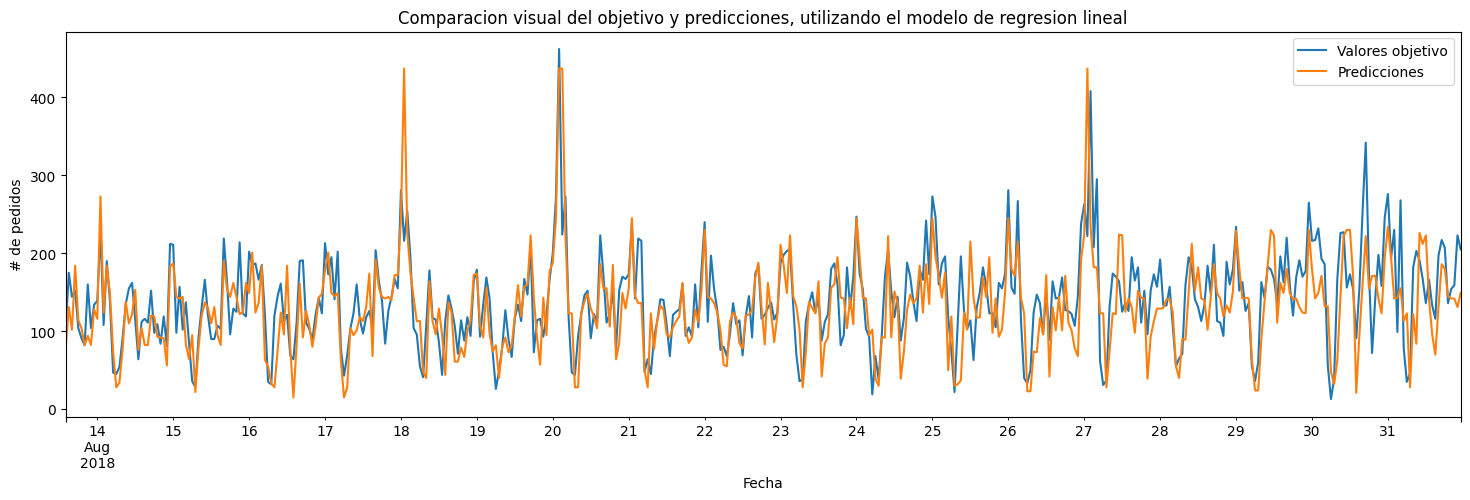

In [20]:
# Comparacion visual objetivo y predicciones ---------------------------
plt.figure(figsize=(18, 5))
target_test.plot(ax=plt.gca(),title='Comparacion visual del objetivo y predicciones, utilizando el modelo de regresion lineal')
pd.Series(prediction,index=features_test.index).plot()
plt.legend( ['Valores objetivo', 'Predicciones'])
plt.xlabel('Fecha')
plt.ylabel('# de pedidos')
plt.show()

# Lista de revisión

- [x]  	
Jupyter Notebook está abierto.
- [ ]  El código no tiene errores
- [ ]  Las celdas con el código han sido colocadas en el orden de ejecución.
- [ ]  	
Los datos han sido descargados y preparados.
- [ ]  Se ha realizado el paso 2: los datos han sido analizados
- [ ]  Se entrenó el modelo y se seleccionaron los hiperparámetros
- [ ]  Se han evaluado los modelos. Se expuso una conclusión
- [ ] La *RECM* para el conjunto de prueba no es más de 48